##Import Neural Network Dependencies

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
import re

##Import Plotting Libraries

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

##Import NLP Libraries

In [121]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import Zero Knowledge

In [122]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl

In [123]:
# Specify all the files we need

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')
cal_data_path = os.path.join('cal_data.json')

In [124]:
!wget https://raw.githubusercontent.com/lipet2k/verifiable-social-media/main/security_dataset/github_data_UTF.csv -O bot_detection_data.csv

file_path = 'bot_detection_data.csv'

--2023-09-24 04:16:51--  https://raw.githubusercontent.com/lipet2k/verifiable-social-media/main/security_dataset/github_data_UTF.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5773419 (5.5M) [text/plain]
Saving to: ‘bot_detection_data.csv’

bot_detection_data. 100%[===================>]   5.51M  --.-KB/s    in 0.02s   

2023-09-24 04:16:52 (268 MB/s) - ‘bot_detection_data.csv’ saved [5773419/5773419]



In [125]:
# Read in csv file + Remove uncessary columns

df_data = pd.read_csv(file_path)
df_data = df_data.iloc[:13500000]
print(df_data.head())

             id                id_str       screen_name  \
0  8.160000e+17  "815745789754417152"  "HoustonPokeMap"   
1  4.843621e+09            4843621225         kernyeahx   
2  4.303727e+09            4303727112   mattlieberisbot   
3  3.063139e+09            3063139353         sc_papers   
4  2.955142e+09            2955142070      lucarivera16   

                    location  \
0              "Houston, TX"   
1  Templeville town, MD, USA   
2                        NaN   
3                        NaN   
4      Dublin, United States   

                                         description  \
0  "Rare and strong PokŽmon in Houston, TX. See m...   
1  From late 2014 Socium Marketplace will make sh...   
2  Inspired by the smart, funny folks at @replyal...   
3                                                NaN   
4             Inspiring cooks everywhere since 1956.   

                         url  followers_count  friends_count  listed_count  \
0  "https://t.co/dnWuDbFRkt"         

##Clean and Tokenize text

In [126]:
tk = TweetTokenizer()

def clean_text(text):
  if type(text) is str:
    text = tk.tokenize(text)
    return ' '.join(text)
  return ""

In [127]:
df_tokenized = df_data['description'].apply(clean_text)
df_usernames = df_data['screen_name']

for i in range(len(df_tokenized)):
  user_name = df_usernames[i]
  # hash_tags = df_hashtags[i]
  tweet_array = df_tokenized[i]
  tweet_array.join(' ' + user_name)
  # if type(hash_tags) is not float:
  #   string_tags = ' '.join(hash_tags)
  #   tweet_array.join(string_tags)
print(df_tokenized.head()[0])

" Rare and strong PokŽmon in Houston , TX . See more PokŽmon at https://t.co/dnWuDbFRkt "


In [128]:
X_train, X_test, y_train, y_test = train_test_split(df_tokenized, df_data['bot'], test_size=0.3, random_state=125)

print(y_train)
print(y_test)

2660    0
2621    0
2637    0
150     1
607     1
       ..
1646    0
1859    0
1279    1
1250    1
2205    0
Name: bot, Length: 1957, dtype: int64
1042    1
1886    0
2468    0
1509    0
430     1
       ..
2100    0
1684    0
1579    0
1037    1
2311    0
Name: bot, Length: 840, dtype: int64


## Naive Bayes

In [129]:
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer(max_features=36)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

test_score = nb.score(X_test_vec, y_test)
train_score = nb.score(X_train_vec, y_train)

print('Training score: ' + str(train_score))
print('Testing score: ' + str(test_score))

Training score: 0.7020950434338273
Testing score: 0.7119047619047619


In [130]:
print(X_train_vec.shape)
print(X_test_vec.shape)

(1957, 36)
(840, 36)


## Wrap sk model with PyTorch

Comment out the other sections besides the model that you would like to export to solidity verifier

### Logistic Regression

In [131]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sk2torch"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass
import sk2torch

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

vectorizer = CountVectorizer(max_features=36)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression())
pipe.fit(X_train_vec, y_train)

test_score = pipe.score(X_test_vec, y_test)
train_score = pipe.score(X_train_vec, y_train)

print('Training score: ' + str(train_score))
print('Testing score: ' + str(test_score))

Training score: 0.7164026571282576
Testing score: 0.7202380952380952


## SVM

In [133]:
from sklearn.svm import SVC

svc = SVC()

vectorizer = CountVectorizer(max_features=36)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

dense_x_train = np.asarray(X_train_vec.todense()).astype(float)
dense_x_test = np.asarray(X_test_vec.todense()).astype(float)
svc.fit(dense_x_train, y_train)

test_score = svc.score(dense_x_test, y_test)
train_score = svc.score(dense_x_train, y_train)

print('Training score: ' + str(train_score))
print('Testing score: ' + str(test_score))

Training score: 0.7777210015329586
Testing score: 0.7285714285714285


In [134]:
model = sk2torch.wrap(svc)

## Export

In [135]:
import matplotlib.pyplot as plt

# export to onnx format
# !!!!!!!!!!!!!!!!! This will flash a warning but it is fine !!!!!!!!!!!!!!!!!!!!!

# Input to the model

sample = np.array(dense_x_test[0].reshape(1, 36))[0]

x = torch.tensor(sample, requires_grad=True).reshape(1, 36)

torch_out = model.predict(x)
# Export the model
torch.onnx.export(model,               # model being run
                  # model input (or a tuple for multiple inputs)
                  x,
                  # where to save the model (can be a file or file-like object)
                  "network.onnx",
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                'output': {0: 'batch_size'}})

d = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data=[d])

# Serialize data into file:
json.dump(data, open(data_path, 'w'))

# use the test set to calibrate the circuit
cal_data = dict(input_data = dense_x_test.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, 'w'))

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/usr/local/lib/python3.10/dist-packages/sk2torch/svc.py:193: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  votes = torch.zeros((len(x), self.n_classes)).to(kernel_out)
/usr/local/lib/python3.10/dist-packages/sk2torch/svc.py:195: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  torch.zeros(len(x)).to(kernel_out) for i in range(self.n_classes)


In [136]:
!RUST_LOG=trace
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")  # Optimize for resources
assert res == True

In [137]:
res = ezkl.compile_model(model_path, compiled_model_path, settings_path)
assert res == True

In [138]:
res = ezkl.get_srs(srs_path, settings_path)

In [139]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
        settings_path
    )


assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [140]:
# Generate the Witness for the proof

# now generate the witness file
witness_path = os.path.join('witness.json')

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, settings_path)
assert os.path.isfile(witness_path)

In [141]:
# Generate the proof

proof_path = os.path.join('proof.json')

proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "evm",
        "single",
        settings_path
    )

print(proof)
assert os.path.isfile(proof_path)

{'instances': [[[12436184717236109307, 3962172157175319849, 7381016538464732718, 1011752739694698287]]], 'proof': '1791aa3aa7110a01aee40097e73b9bde8c3736d82dbe5cf5329c9a61689ade9422d373e19bea056a78be2c108372a8fbfa2469ed8048bc974c60f0ada174877e2560970ffdeffa297fc1706d5a70fd71f1287a902f653e432253c6688c7b89b3069e7ec5b1abfdff8a41e768666aad0793d4c5006f37525882ae648f0358cf1e23d1733b29688e35a731de49063598904f8b574dc8c56b7eb9e0f0a00acf201e24d861ca1e910158fc1796016af986f7ccf2840b90e7488cc40ba3267d2fb2c12f2baf0bb41ba97a5d6db76c138e1ca365da65713df2ec62659771ebca0beec0283fbf9009cbe9899963e6f9ac8325d23300289ce2198bc7a66597ae259bb1df1a679e11833cef22ff3833ce74d2a2a0b0f55a1f4aeb3e4c37e6f1643939ba5810e2723f0382cd145d3d4cc2721302a7a4cdb074256d4dbe2545f3eb7ce3d5dd045e0fc8627573964577d2deb62cfaa121e173c98b52399a8528c60819c587602d8ca8d2c963bdbfa52eeb5b8860ce0534839eb313e390e7913943022743857a2517491fd275cf5667bcae6a688d7fc1a88bc12edaad56dc0d79808b3fa4e26e038c1204f07b22fb0889cf1a3905f69710830ce38408f597b7888

In [156]:
# verify our proof

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

verified


### CNN

In [143]:
# TODO: 1d convolution has a shape bug making it difficult
# class NNModel(nn.Module):
#     # define nn
#     def __init__(self, num_channels, classes):
#         super(NNModel, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=50, kernel_size=2)
#         self.relu1 = nn.ReLU()
#         self.maxpool1 = nn.MaxPool1d(kernel_size=2)

#         self.conv2 = nn.Conv1d(in_channels=50, out_channels=25, kernel_size=2)
#         self.relu2 = nn.ReLU()
#         self.maxpool2 = nn.MaxPool1d(kernel_size=2)

#         self.fc1 = nn.Linear(in_features=1763, out_features=10)
#         self.relu3 = nn.ReLU()

#         self.fc2 = nn.Linear(in_features=10, out_features=classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.maxpool1(x)

#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.maxpool2(x)

#         x = torch.flatten(x, 1)

#         x = self.fc1(x)
#         x = self.relu3(x)

#         x = self.fc2(x)

#         return x

# model = NNModel(num_channels=X_train.shape[0], classes=1)

### Feedforward NN

In [144]:
class Model(nn.Module):
    # define nn
    def __init__(self, num_channels, classes):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=num_channels, out_features=50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 25)
        self.fc5 = nn.Linear(in_features=25, out_features=classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.relu(x)

        x = self.fc5(x)
        x = self.relu(x)

        return x

# Initialize Model
num_channels=36
classes = 1
model = Model(num_channels=num_channels, classes=classes)

## Training a Neural Network

In [145]:
# our loss function
loss_fn = nn.CrossEntropyLoss()

# our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     model.to(device)
#     print("Model moved to GPU")
# else:
#     print("GPU is not available, using CPU instead")

# use 800 EPOCHS
EPOCHS = 100

# Convert training data to pytorch variables
X_train_tensor = torch.from_numpy(X_train_vec.todense()).float()
X_test_tensor = torch.from_numpy(X_test_vec.todense()).float()
y_train_tensor = torch.from_numpy(np.array(y_train)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float()

print(y_train_tensor.shape)

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))


# we use tqdm for nice loading bars
for epoch in tqdm.trange(EPOCHS):

    # To train, we get a prediction from the current network
    predicted_y = model(X_train_tensor)

    # Compute the loss to see how bad or good we are doing
    loss = loss_fn(predicted_y.squeeze(), y_train_tensor)

    # Append the loss to keep track of our performance
    loss_list[epoch] = loss.item()

    # Afterwards, we will need to zero the gradients to reset
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate the accuracy, call torch.no_grad() to prevent updating gradients
    # while calculating accuracy
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        correct = (torch.argmax(y_pred, dim=1) == y_test_tensor).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

torch.Size([1957])


100%|██████████| 100/100 [00:00<00:00, 416.23it/s]


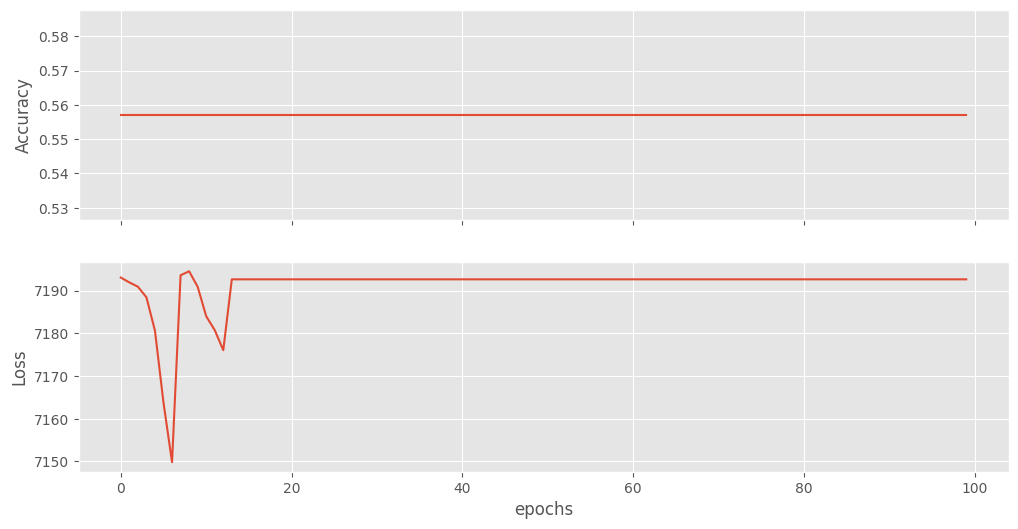

In [146]:
# Plot the Accuracy and Loss

# import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')


fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("Accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("Loss")
ax2.set_xlabel("epochs");

In [147]:
# After training, export to onnx (network.onnx) and create a data file (input.json)

# create a random input
x = X_test_tensor[0].reshape(1, 36)

# Flips the neural net into inference mode
model.eval()

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump(data, open(data_path, 'w'))


# use the test set to calibrate the circuit
cal_data = dict(input_data = X_test_tensor.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, 'w'))


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [148]:
!RUST_LOG=trace
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")  # Optimize for resources
assert res == True

In [149]:
res = ezkl.compile_model(model_path, compiled_model_path, settings_path)
assert res == True

In [150]:
res = ezkl.get_srs(srs_path, settings_path)

In [151]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
        settings_path
    )


assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [152]:
# Generate the Witness for the proof

# now generate the witness file
witness_path = os.path.join('witness.json')

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, settings_path)
assert os.path.isfile(witness_path)

In [153]:
# Generate the proof

proof_path = os.path.join('proof.json')

proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "evm",
        "single",
        settings_path
    )

print(proof)
assert os.path.isfile(proof_path)

{'instances': [[[0, 0, 0, 0]]], 'proof': '10939381fc34c9dd8a862f65fc0d1267fbcb41c2febf279c4da8aff19b0446682a2987e8820ac4ebdf7604402756a4f0702c931b2f2d0aee8de1d44cf891f5441f4fc0aaef0724ade9f42ab375a96494cc76fbd7eeab98bcfb4405c084572bca0f9a743df6efe0e0fcbe328ade0a97b9bfee5162e4a2a96409e9428fd6514e140469b430dcec457386a2f5a8108be0ced72d03e6bcdb0d6ba54edf161a6884d10c57e97033b5fe65ae9ac2825cee38de01554d01bbb12d58167a36118721dbf408cad4cbd32f713ecacf44bb72e3d1c9b7c300cf884c8b7e8b396b59e6fccd9f21d2671aca3be511bfc3b22de61ad6a31682950a097a2d832b5dc331e381be2b10e5c979d7f3ef25fa8f4eb616300ae9cef530b4c7273236df5ab402250dffc11a3d1aa36a55eded43f0a619d46d80439ec6373314cd736c8c231995c21faf361d6aeb0571633de9f8fe5d6f9b5b35eaa38475afbc8b9b6d518e3f3af515f04c2c094ffc82dca1706037fc5e7ed1e39f2263c132e55182831fcbd7e33b238586001421ead1d0683fb22944221d04a9d005ea013a58aeebf35930ff2681dcb3ac2013c0f8e00ca65cc21453670fa0caa19fc5c3cac2e51596d34448211aa39a9b226c2948bb52ff56e2db723ee8dfccbf70f06146ef757309804ee06b7ce25d

In [154]:
# verify our proof

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

verified
